In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DIN Alternate'
mpl.rcParams['figure.dpi'] = 100
plt_dpi = None # change to 500-1000 later

## Related Custom Functions

In [2]:
# pretty print skewness and kurtosis
def get_moments(log_ret):
    """ 
    Input: Log-returns
    Output: Skewness and kurtosis
    """
    d = {
        'Skewness': log_ret.skew(),
        'Kurtosis': log_ret.kurtosis()   
    }
    return pd.DataFrame(data=d)

In [3]:
# pretty print volatility of log-returns
def get_volatility(log_ret):
    """ 
    Input: Log-returns
    Output: Volatility - daily, monthly, annually
    """
    daily_vol = log_ret.std()
    d = {
        'Daily': daily_vol,
        'Monthly': np.sqrt(21) * daily_vol,
        'Annually': np.sqrt(252) * daily_vol
    }
    return pd.DataFrame(data=d)

# Computer Assignment 1
## Univariate Volatility Models

## 1. Daily volatility forecast using MA and EWMA
Perform a daily volatility forecast using MA and EWMA with a 60 day estimation window, over the time period 2017-01-01 -> 2020-12-31 for the Dow Jones index (^DJI). Plot the daily forecasts in the same plot.

*Discussion: What is the main reason for the differences in these two forecasts?*

### Fetch data and explore a bit...

In [4]:
# import data
ticker_id = '^DJI'
dji_dat1 = yf.Ticker(ticker_id).history(start='2016-09-01', end='2020-12-31')

In [5]:
# explore data
dji_dat1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-08-31,18436.699219,18439.679688,18333.560547,18400.880859,98250000,0,0
2016-09-01,18396.570312,18430.050781,18295.480469,18419.300781,74780000,0,0
2016-09-02,18466.009766,18544.759766,18439.099609,18491.960938,74350000,0,0
2016-09-06,18493.400391,18551.539062,18450.320312,18538.119141,83710000,0,0
2016-09-07,18527.710938,18536.890625,18474.769531,18526.140625,67570000,0,0


In [6]:
# explore data
dji_dat1.shape

(1091, 7)

In [7]:
# extract closing prices
dji_price = dji_dat1[['Close']]
dji_price.head()

,Close
Date,
2016-08-31,18400.880859
2016-09-01,18419.300781
2016-09-02,18491.960938
2016-09-06,18538.119141
2016-09-07,18526.140625


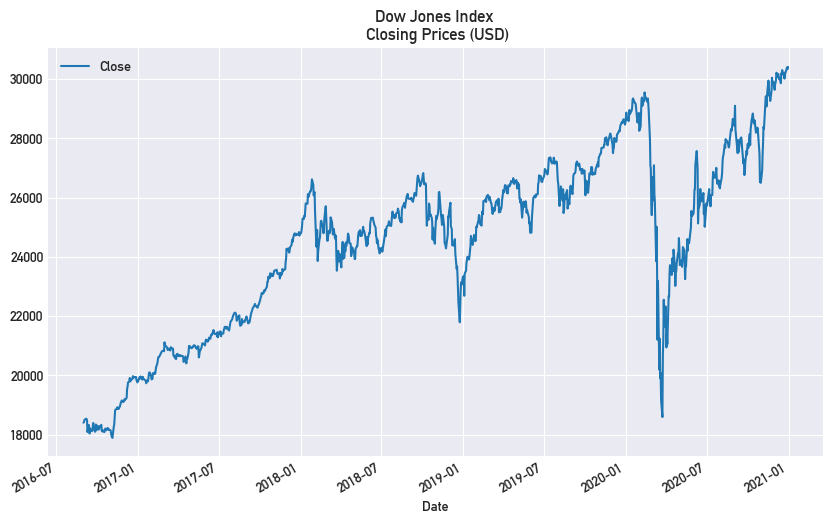

In [8]:
# plot closing prices
dji_price.plot(
    title='Dow Jones Index \n Closing Prices (USD)',
    figsize=(10,6)
)
plt.show()

## Returns

In [9]:
# percentage returns
dji_pct = dji_price.pct_change().dropna()
dji_pct.head()

,Close
Date,
2016-09-01,0.001001
2016-09-02,0.003945
2016-09-06,0.002496
2016-09-07,-0.000646
2016-09-08,-0.002495


### Percentage returns

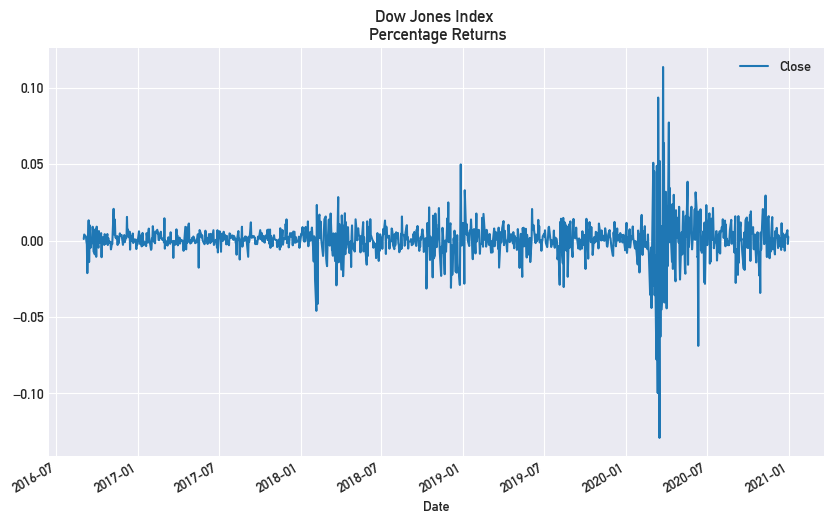

In [10]:
# plot pct returns
dji_pct.plot(
    title='Dow Jones Index \n Percentage Returns',
    figsize=(10,6)
)
plt.show()

### Gross returns

In [11]:
# gross returns
dji_gross = 1 + dji_pct
dji_gross.head()

,Close
Date,
2016-09-01,1.001001
2016-09-02,1.003945
2016-09-06,1.002496
2016-09-07,0.999354
2016-09-08,0.997505


### Log-returns

In [12]:
# log-returns
dji_log = np.log(dji_price).diff().dropna()
dji_log.columns = ['Log returns']
dji_log.head()

,Log returns
Date,
2016-09-01,0.001001
2016-09-02,0.003937
2016-09-06,0.002493
2016-09-07,-0.000646
2016-09-08,-0.002499


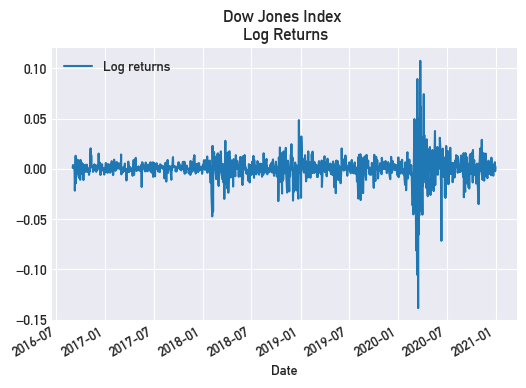

In [13]:
# plot log-returns
dji_log.plot(
    title='Dow Jones Index \n Log Returns',
)
plt.show()

In [14]:
# related statistics
dji_log.describe().T

,count,mean,std,min,25%,50%,75%,max
Log returns,1090.0,0.000461,0.01329,-0.138418,-0.003101,0.000883,0.005216,0.107643


In [15]:
# change percentiles
dji_log.describe([0.05, 0.95]).T

,count,mean,std,min,5%,50%,95%,max
Log returns,1090.0,0.000461,0.01329,-0.138418,-0.018431,0.000883,0.0158,0.107643


In [16]:
# check skewness and kurtosis
get_moments(dji_log)

,Skewness,Kurtosis
Log returns,-1.190619,24.595193


In [17]:
# check volatiltity
get_volatility(dji_log)

,Daily,Monthly,Annually
Log returns,0.01329,0.060902,0.21097


## Moving Average Model - window size of 60 days

In [18]:
# create data from 2017-01-01 minus 60 days
win_size = 60
val = dji_log.loc['2017-01-01':].iloc[0].values[0]
start_idx = int(np.where(dji_log['Log returns'] == val)[0]) - win_size
dat_60d = dji_log.iloc[start_idx:]

In [19]:
# create MA(60) model (we don't assume zero mean return)
dji_ma = dat_60d.rolling(window=win_size).std()
dji_ma.columns = ['MA (built-in)']
dji_ma = dji_ma.loc['2017-01-01':]
dji_ma.describe().T

,count,mean,std,min,25%,50%,75%,max
MA (built-in),1006.0,0.010552,0.008738,0.003451,0.004862,0.00768,0.012182,0.04294


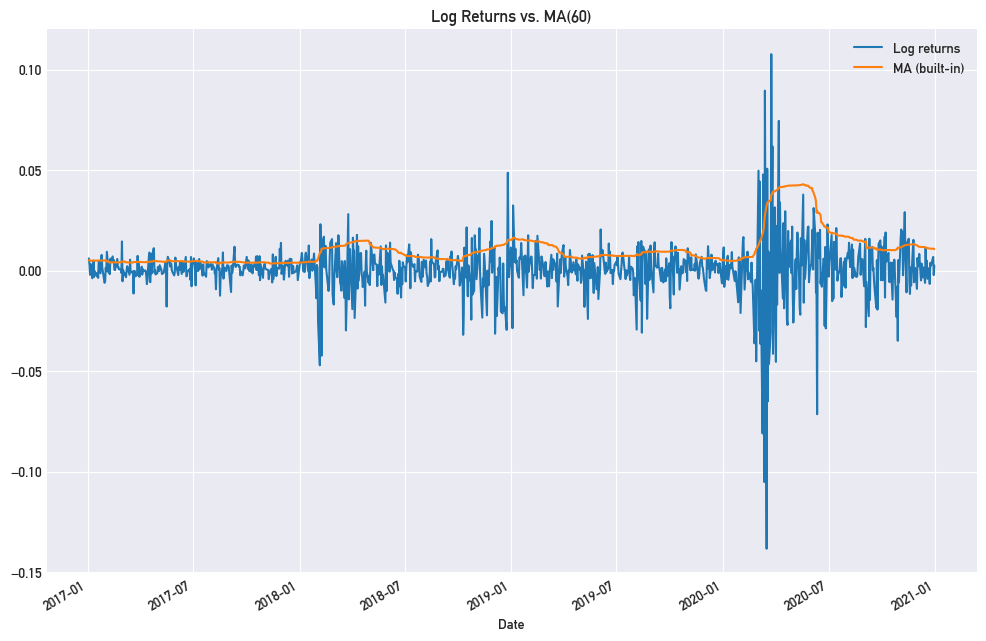

In [20]:
# compare MA(60) to the log-returns
ax = dji_log.loc['2017-01-01':].plot(
    figsize=(12,8),
    title='Log Returns vs. MA(60)'
)
dji_ma.plot(ax=ax)
plt.show()

## EWMA Model - window size of 60 days

### Built-in method for EWMA

In [21]:
# create ewma by pd function - compute inital std to enable correct computations
""" init_std = dji_log.rolling(window=win_size).std()[:win_size]
dji_ewma = pd.concat([init_std, dji_log[win_size:]]).ewm(span=win_size, adjust=False).std()
dji_ewma.columns = ['EWMA (built-in)']
dji_ewma.describe().T """

" init_std = dji_log.rolling(window=win_size).std()[:win_size]\ndji_ewma = pd.concat([init_std, dji_log[win_size:]]).ewm(span=win_size, adjust=False).std()\ndji_ewma.columns = ['EWMA (built-in)']\ndji_ewma.describe().T "

### Compare from-scratch methods to built-in for EWMA

In [22]:
# non-simplified formula for EWMA
lbd = 0.94 # lambda, decay
win_size = 60 # window size
init_constant = (1 - lbd) / (lbd * (1 - np.power(lbd, win_size))) # constant
horizon = dat_60d.shape[0] - win_size # compute forecast horizon
lbd_vec = np.array([lbd**i for i in np.arange(1, win_size + 1)]) # lambda to the power of i, vector

y = dat_60d.values
res_brute = np.zeros(horizon) # memory allocation

# execute EWMA recursions
for i in np.arange(horizon):
    sqrd_ret = np.flip(np.square(y[i:(win_size + i)])) # squared and reversed returns
    res_brute[i] = init_constant * (lbd_vec @ sqrd_ret)

dji_ewma_bf = dat_60d.loc['2017-01-01':].drop(columns=["Log returns"]).copy(deep=True)
dji_ewma_bf["EWMA (brute)"] = np.sqrt(res_brute)
dji_ewma_bf = dji_ewma_bf.loc['2017-01-01':]

In [23]:
# simplified EWMA, approximation where T is large (tend to infinity)
lbd = 0.94 # lambda, decay
win_size = 60 # window size
init_constant = (1 - lbd) / (lbd * (1 - np.power(lbd, win_size))) # constant

init_log = np.flip(np.square(dat_60d.values[:win_size])) # reversed log returns, latest first
lbd_vec = np.array([lbd**i for i in np.arange(1, win_size + 1)]) # lambda to the power of i, vector
init_var = init_constant * (lbd_vec @ init_log) # initial variance

res = np.zeros(dat_60d.shape[0] - win_size) # memory allocation 
res[0] = init_var # initial variance from base formula
log_ret = dat_60d.values[win_size:] # base forthcoming results after the 60 first observations

# execute EWMA recursions
for i in np.arange(1, log_ret.shape[0]):
    val = (1 - lbd) * np.square(log_ret[i - 1]) + lbd * res[i - 1]
    res[i] = val

dji_ewma_s = dat_60d.loc['2017-01-01':].drop(columns=["Log returns"]).copy(deep=True) # deep copy of df, keep date column
dji_ewma_s['EWMA (approximate)'] = np.sqrt(res) # sqrt to get volatility
dji_ewma_s = dji_ewma_s.loc['2017-01-01':]

Difference between EWMA methods (from-scratch): 0.00006


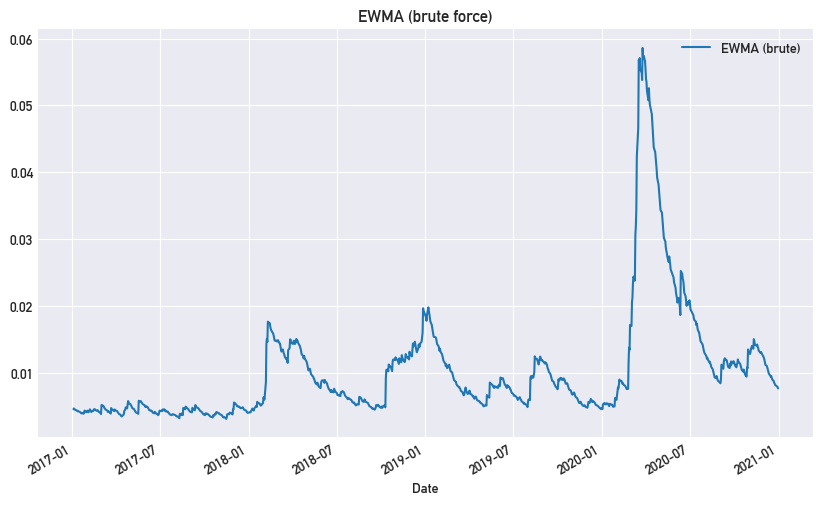

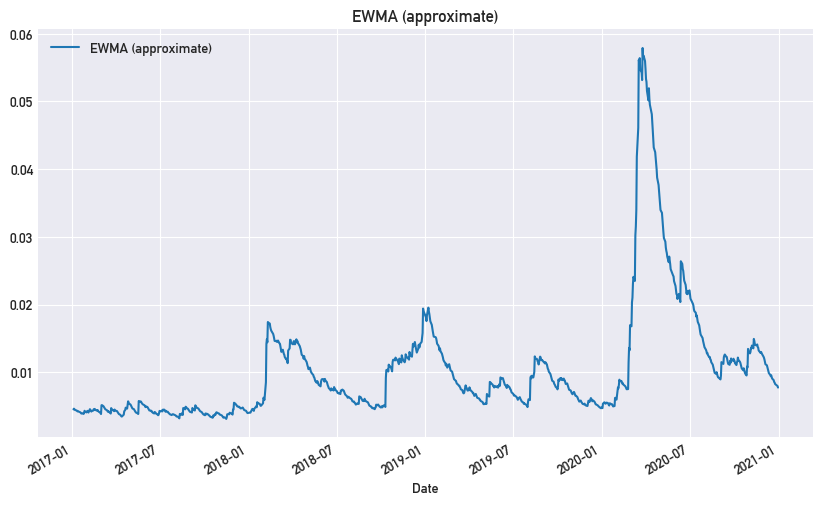

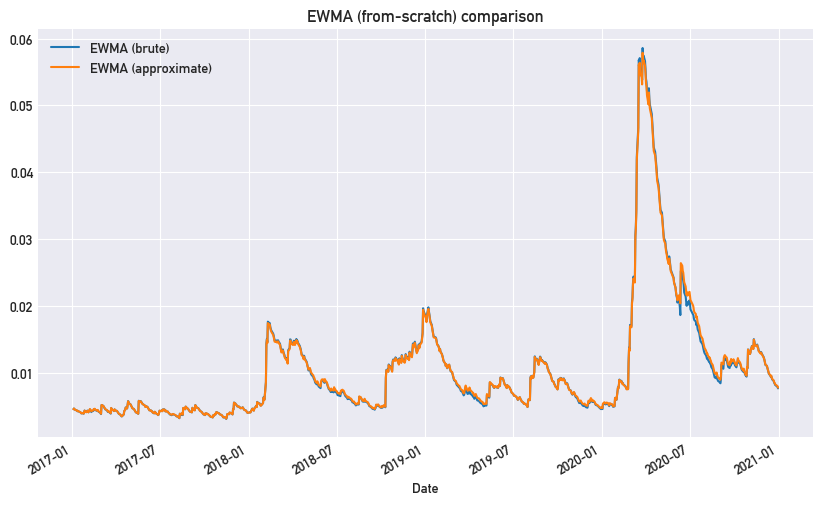

In [24]:
# compare difference between brute and simplified EWMA
diff = np.nanmean(dji_ewma_s.values - dji_ewma_bf.values)
print('Difference between EWMA methods (from-scratch): {:.5f}'.format(diff))

# plot results (brute-force)
dji_ewma_bf.plot(
    figsize=(10,6),
    title='EWMA (brute force)'
)
plt.show()

# plot results (simplified)
dji_ewma_s.plot(
    figsize=(10, 6),
    title='EWMA (approximate)'
)
plt.show()

# plot from-scratch methods comparison
ax = dji_ewma_bf.plot(
    figsize=(10,6),
    title="EWMA (from-scratch) comparison"
)
dji_ewma_s.plot(ax=ax)
plt.show()

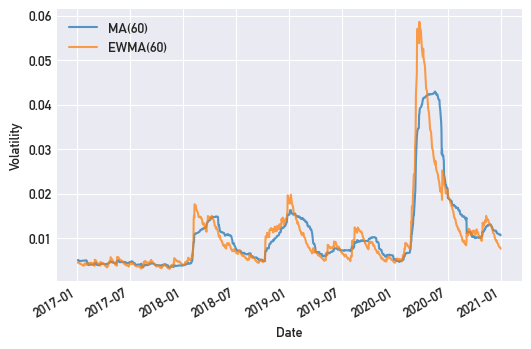

In [25]:
# compare MA and EWMA
ax = dji_ma.plot(alpha=.75)
dji_ewma_bf.plot(ax=ax, alpha=.75) # brute force
plt.legend(['MA(60)', 'EWMA(60)'])
plt.ylabel('Volatility')
plt.savefig('plot/comparison_task1.png', dpi=plt_dpi)
plt.show()

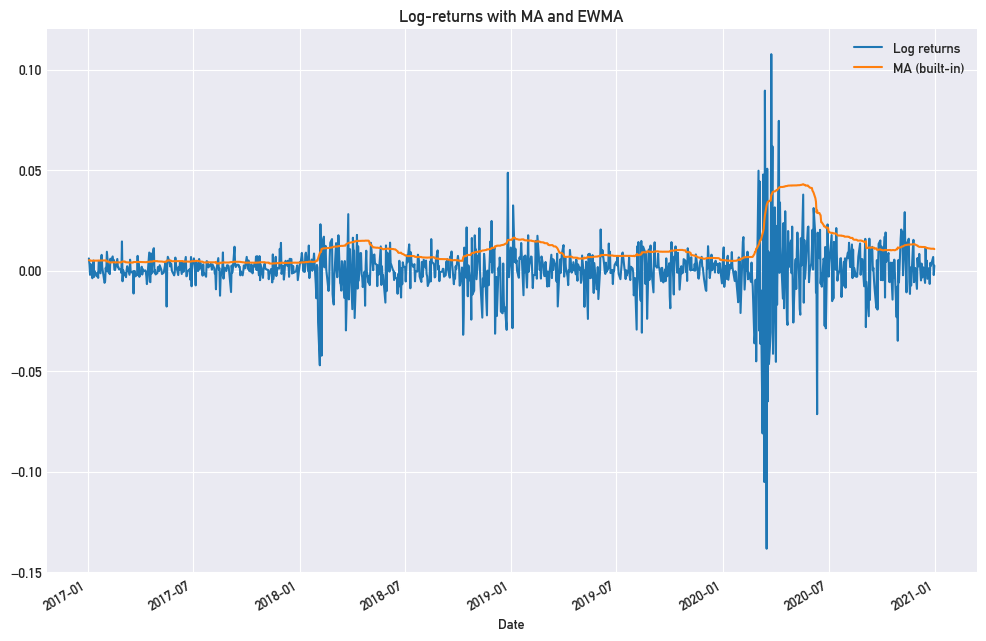

In [26]:
# compare MA(60), EWMA(60) to the log-returns
ax = dji_log.loc['2017-01-01':].plot(
    figsize=(12,8),
    title='Log-returns with MA and EWMA'
)
dji_ma.plot(ax=ax)
plt.show()

## 2. Daily volatility forecast using GARCH
Fit a GARCH(1,1)-model using Dow Jones return data for the time period 2007-01-01 -> 2016-12-31 and then perform a daily volatility forecast as in 1. Plot your daily forecast in the same plot as in 1. 

*Discussion: What is the main reason for the difference between the GARCH and the EWMA forecast?*

### Fetch data and extract log returns

In [27]:
dji_dat2 = yf.Ticker(ticker_id).history(start='2007-01-01', end='2016-12-31')
dji_dat2.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-01-03,12459.540039,12580.349609,12404.820312,12474.519531,327200000,0,0
2007-01-04,12473.160156,12510.410156,12403.860352,12480.690430,259060000,0,0
2007-01-05,12480.049805,12480.129883,12365.410156,12398.009766,235220000,0,0
2007-01-08,12392.009766,12445.919922,12337.370117,12423.490234,223500000,0,0
2007-01-09,12424.769531,12466.429688,12369.169922,12416.599609,225190000,0,0


In [28]:
dji_price2 = dji_dat2[['Close']]
dji_price2.head()

,Close
Date,
2007-01-03,12474.519531
2007-01-04,12480.690430
2007-01-05,12398.009766
2007-01-08,12423.490234
2007-01-09,12416.599609


In [29]:
dji_log2 = np.log(dji_price2).diff().dropna()
dji_log2.columns = ['Log returns']
dji_log2.head()

,Log returns
Date,
2007-01-04,0.000495
2007-01-05,-0.006647
2007-01-08,0.002053
2007-01-09,-0.000555
2007-01-10,0.002056


In [30]:
dji_log2.shape

(2517, 1)

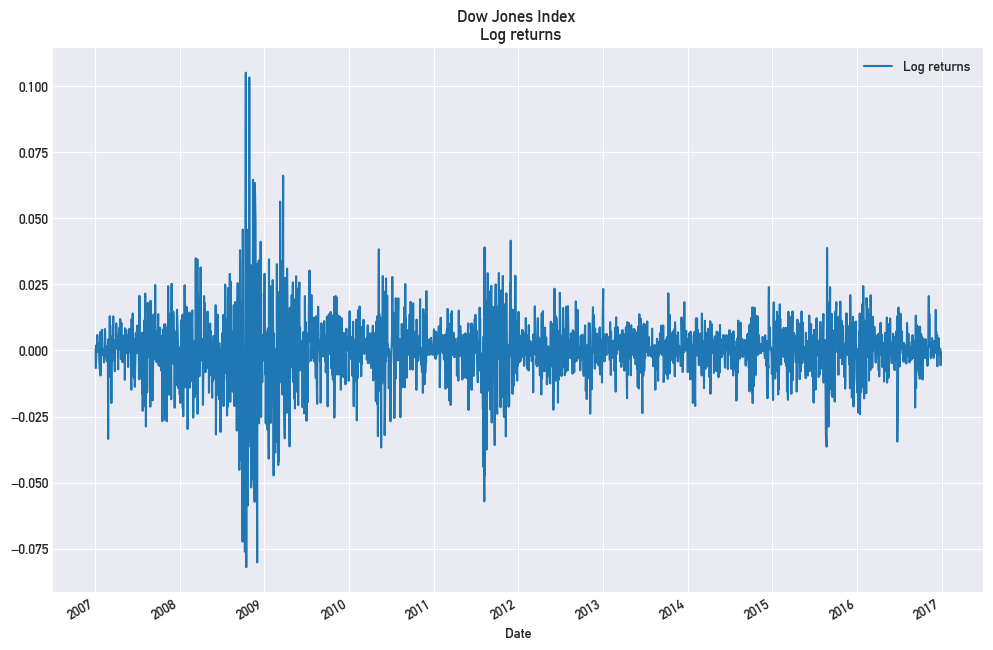

In [31]:
dji_log2.plot(
    figsize=(12,8),
    title='Dow Jones Index \n Log returns'
)
plt.show()

### Create and fit GARCH model

GARCH parameter optimization by Scipy.

In [123]:
# create GARCH object
class GARCH(object):
    def __init__(self, log_ret):
        self.log_ret = log_ret['Log returns'] * 100
        self.params = self.optimize()
        df = log_ret.drop(columns=["Log returns"]).copy(deep=True)
        fitted_var = self.get_recursions(self.params, self.log_ret)
        df['GARCH'] = np.sqrt(fitted_var) / 100
        self.vol = df
        self.fcst_params = (self.log_ret[-1], fitted_var[-1])
    
    def optimize(self):
        init_params = (.1, .05, .92)
        params = minimize(
            fun=self.loglik,
            x0=init_params,
            args=(self.log_ret),
            bounds=((.0001,1), (.0001,1), (.0001,1))
        )
        return params.x

    def get_recursions(self, params, log_ret, fcst=False):
        omega, alpha, beta = params[0], params[1], params[2]
        T = log_ret.shape[0]
        var = np.zeros(T)
        if fcst:
            log_ret = np.insert(log_ret.values, 0, self.fcst_params[0])
            var = np.insert(var, 0, self.fcst_params[1])
        else:
            var[0] = log_ret.var() # sample variance

        for i in range(1, T):
            var[i] = omega + alpha * np.square(log_ret[i-1]) + beta * var[i-1]
        return var

    def loglik(self, params, log_ret):
        var = self.get_recursions(params, log_ret)
        loglik_fun = np.sum(np.log(var) + np.square(log_ret) / var)
        return loglik_fun # negative due to minimization problem

    def forecast(self, params, log_ret):
        res = self.get_recursions(params, log_ret['Log returns'] * 100, fcst=True)[1:]
        df = log_ret.drop(columns=["Log returns"]).copy(deep=True)
        df['GARCH'] = np.sqrt(res) / 100
        return df

In [124]:
# fit model (Scipy)
mdl = GARCH(log_ret=dji_log2)

# display estimated params (Scipy)
mdl.params

array([0.02901952, 0.1268963 , 0.84873246])

In [125]:
test = np.ones(5)
test1 = np.insert(test, 0, 9)
test1


array([9., 1., 1., 1., 1., 1.])

In [126]:
mdl.params[0] / 10000

2.9019515891486195e-06

GARCH parameter optimization by brute-force iteration.

In [127]:
# separate functions for "brute-force" optimization
def get_recursions(params, log_ret):
        omega, alpha, beta = params[0], params[1], params[2]
        T = log_ret.shape[0]
        var = np.zeros(T)
        var[0] = log_ret.var() # sample variance
        for i in range(1, T):
            var[i] = omega + alpha * np.square(log_ret[i-1]) + beta * var[i-1]
        return var

def loglik(params, log_ret):
    var = get_recursions(params, log_ret)
    loglik_fun = -np.sum(np.log(var) + np.square(log_ret) / var)
    return loglik_fun

In [128]:
# brute-force log-likelihood maximization
init_params = [.1, .05, .92]
omega_grid = np.flip(np.arange(.0268, .0272, .0001))
alpha_grid = np.arange(.129, .132, .001)
beta_grid = np.flip(np.arange(.849, 0.852, .001))

dim = omega_grid.shape[0] * alpha_grid.shape[0] * beta_grid.shape[0]
res = np.empty((dim, 4))
i = 0
dji_ret = dji_log2['Log returns'] * 100
for omega in omega_grid: 
    for alpha in alpha_grid:
        for beta in beta_grid:
            params = np.array([omega, alpha, beta])
            log_lik = loglik(params, dji_ret)
            res[i, :] = np.append(params, log_lik)
            i += 1

In [129]:
# own estimated params
idx = res[:, -1] == np.max(res[:, -1])
est_params = res[idx, :3][0]
est_params

array([0.0271, 0.129 , 0.85  ])

In [130]:
# built-in optimizer for comparison
from arch import arch_model
am = arch_model(dji_log2['Log returns'] * 100)
res = am.fit(update_freq=5)
res.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 3411.7225675621485
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3403.0907361178433
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Log returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3403.09
Distribution:                  Normal   AIC:                           6814.18
Method:            Maximum Likelihood   BIC:                           6837.50
                                        No. Observations:                 2517
Date:                Tue, Sep 28 2021   Df Residuals:                     2516
Time:                        09:07:13   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0605  1.594e-02      3.796  1.470e-04 [2.926e-02,9.172e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0285  6.680e-03      4.266  1.987e-05 [1.541e-02,4.159e-02]
alpha[1]       0.1286  1.757e-02      7.321  2.464e-13   [9.416e-02,  0.163]
beta[1]        0.8479  1.675e-02     50.635      0.000     [  0.815,  0.881]
============================================================================

Covariance estimator: robust
"""

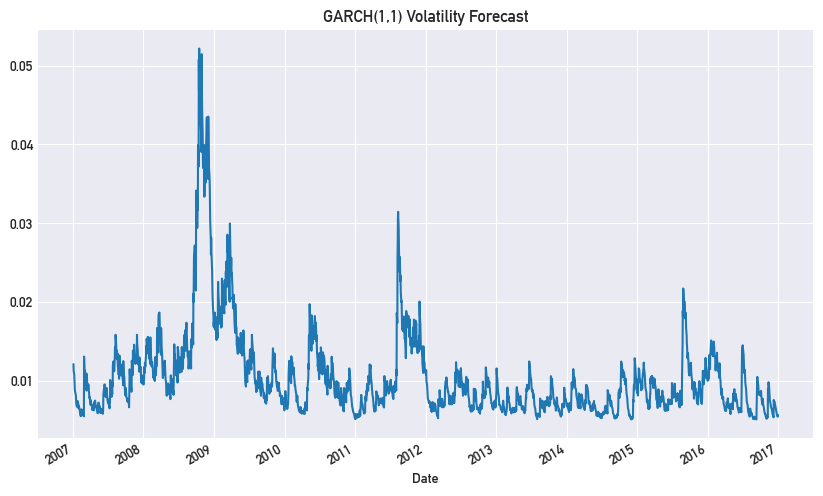

In [131]:
# plot GARCH forecast
mdl.vol['GARCH'].plot(
    figsize=(10,6),
    title='GARCH(1,1) Volatility Forecast'
)
plt.show()

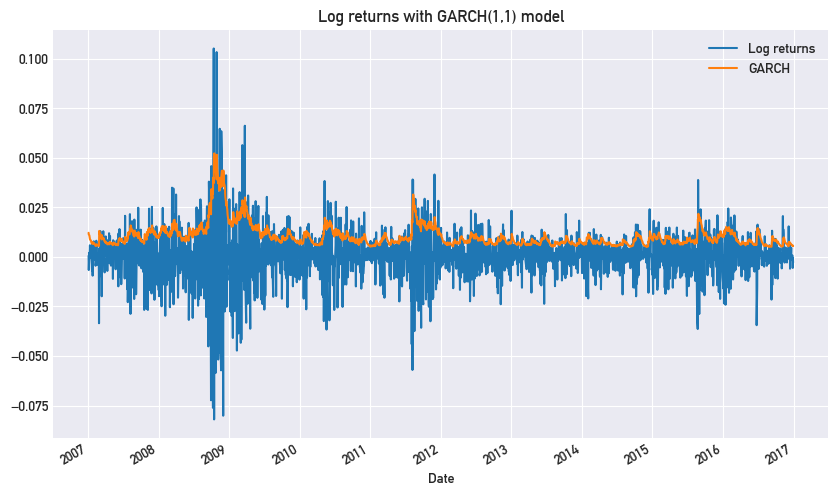

In [132]:
# plot GARCH and log returns
ax = dji_log2.plot(
    figsize=(10,6),
    title='Log returns with GARCH(1,1) model'
)
mdl.vol.plot(ax=ax)
plt.show()

### Forecast 2017-2020 (as in Task 1.)

In [133]:
# split to forecast data
dat_17_20 = dji_log.loc['2017-01-01':]

In [134]:
# perform volatility forecast
garch_fcst = mdl.forecast(mdl.params, dat_17_20)
garch_fcst.head()

,GARCH
Date,
2017-01-03,0.005439
2017-01-04,0.005709
2017-01-05,0.005633
2017-01-06,0.005516
2017-01-09,0.005482


In [135]:
dji_dat_g = yf.Ticker(ticker_id).history(start='2007-01-01', end='2020-12-31')[['Close']]
dji_log_g = np.log(dji_dat_g).diff().dropna()
dji_log_g.columns = ['Log returns']
dji_log_g.head()

,Log returns
Date,
2007-01-04,0.000495
2007-01-05,-0.006647
2007-01-08,0.002053
2007-01-09,-0.000555
2007-01-10,0.002056


In [136]:
(dji_log_g['Log returns'] * 100)[0]

0.049455793583241814

In [137]:
garch_fcst_opt = mdl.forecast(est_params, dat_17_20) #dji_log_g).loc['2017-01-01':]
garch_fcst_opt.columns = ['GARCH (hand-made)']
garch_fcst_opt.head()

,GARCH (hand-made)
Date,
2017-01-03,0.005426
2017-01-04,0.005692
2017-01-05,0.005607
2017-01-06,0.005480
2017-01-09,0.005439


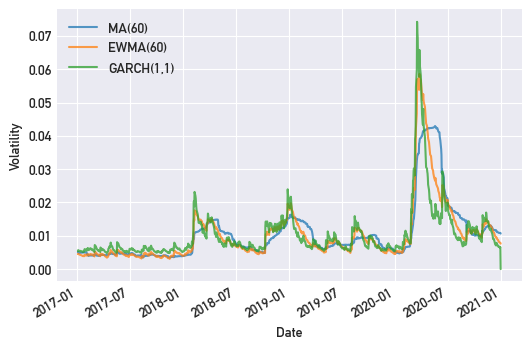

In [138]:
# forecast 2017-2020 compare GARCH with MA(60) and EWMA(60)
ax = dji_ma.plot(alpha=.75)
# dji_ewma.plot(ax=ax)
dji_ewma_bf.plot(ax=ax, alpha=.75)
# garch_fcst.plot(ax=ax) # scipy
garch_fcst_opt.plot(ax=ax, alpha=.75) # brute-force optimization
plt.legend(['MA(60)', 'EWMA(60)', 'GARCH(1,1)'])
plt.ylabel('Volatility')
plt.savefig('plot/comparison_task2.png', dpi=plt_dpi)
plt.show()

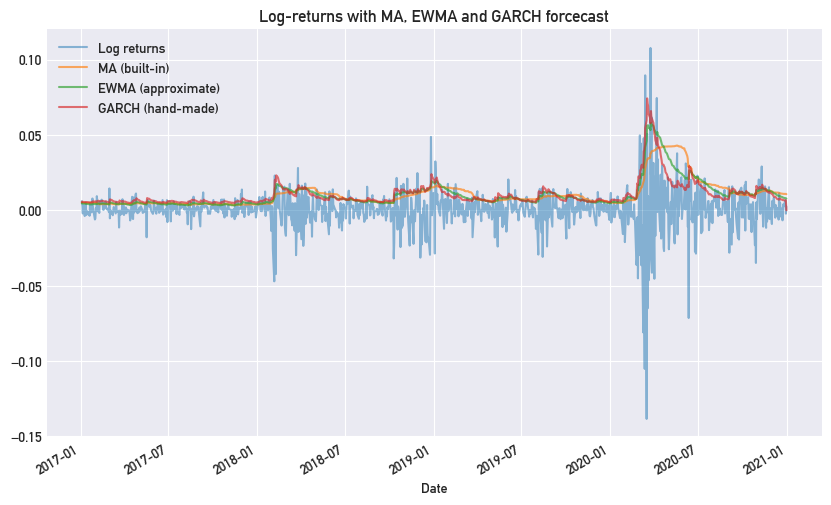

In [139]:
# forecast 2017-2020 compare GARCH with MA(60), EWMA(60) to the log-returns
ax = dat_17_20.plot(
    figsize=(10,6),
    title='Log-returns with MA, EWMA and GARCH forcecast',
    alpha=.5
)
dji_ma.plot(ax=ax, alpha=.65)
dji_ewma_s.plot(ax=ax, alpha=.65)
garch_fcst_opt.plot(ax=ax, alpha=.65)
plt.show()

## 3. GARCH model diagnostics

- a) What are the GARCH-parameters and what is the unconditional volatility?
- b) Plot the ACF (for lag 1 to 200) for the returns and the squared returns. 
- c) Plot the ACF (for lag 1 to 200) for the residuals and the squared residuals. 
- d) Plot a histogram (using 100 bins) of the residuals together with the normal pdf.
- e) QQ-plot the residuals against normal-and student t quantiles. What t-distribution provides the best fit to the lower tail?

*Discussion: What does b) and c) tell you? What does d) and e) tell you?*

In [140]:
# a) What are the GARCH-parameters and what is the unconditional volatility? (scipy)
p = mdl.params
print('Model parameters (omega, alpha, beta): {}'.format(p))
print('Unconditional volatility: {:.3f}'.format(np.sqrt(p[0] / (1 - p[1] - p[2]))))

Model parameters (omega, alpha, beta): [0.02901952 0.1268963  0.84873246]
Unconditional volatility: 1.091


In [141]:
# a) What are the GARCH-parameters and what is the unconditional volatility? (brute force)
p_est = est_params
print('Model parameters (omega, alpha, beta): {}'.format(p_est))
print('Unconditional volatility: {:.3f}'.format(np.sqrt(p_est[0] / (1 - p_est[1] - p_est[2]))))

Model parameters (omega, alpha, beta): [0.0271 0.129  0.85  ]
Unconditional volatility: 1.136


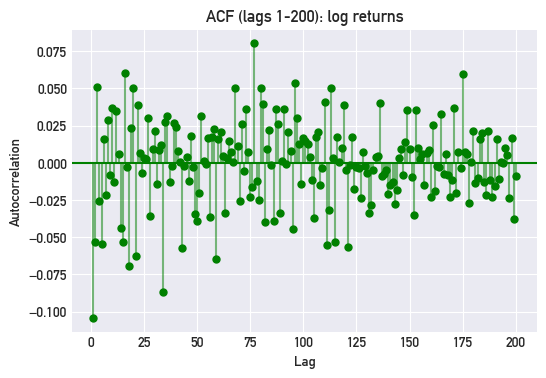

In [142]:
# b) Plot the ACF (for lag 1 to 200) for the returns and the squared returns.
# ACF for log returns
plot_acf(
    dji_log2,
    lags=200,
    zero=False,
    alpha=None,
    title='ACF (lags 1-200): log returns',
    color='green', 
    vlines_kwargs={'colors': 'green', 'alpha': .5}
)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.savefig('plot/3b_1.png', dpi=plt_dpi)
plt.show()

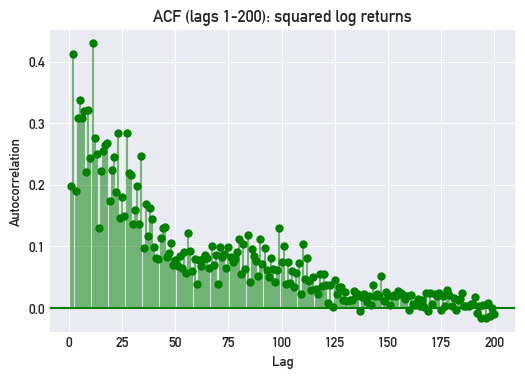

In [143]:
# ACF for squared log returns
plot_acf(
    np.square(dji_log2),
    lags=200,
    zero=False,
    alpha=None,
    title='ACF (lags 1-200): squared log returns',
    color='green', 
    vlines_kwargs={'colors': 'green', 'alpha': .5}
)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.savefig('plot/3b_2.png', dpi=plt_dpi)
plt.show()

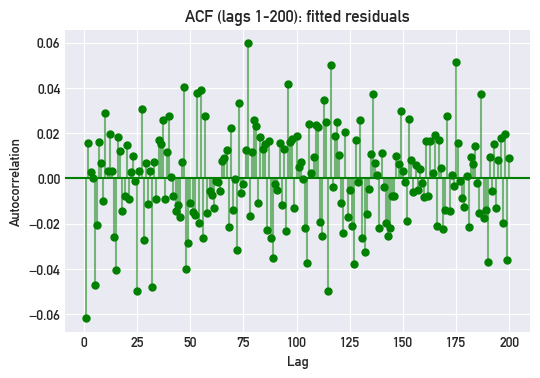

In [148]:
# c) Plot the ACF (for lag 1 to 200) for the residuals and the squared residuals.
# ACF for residuals
est_vol = mdl.vol # mdl.forecast(est_params, dji_log2)
resid = np.true_divide(dji_log2.values[100:], est_vol.values[100:]) # remove first 100 residuals
plot_acf(
    resid,
    lags=200,
    zero=False,
    alpha=None,
    title='ACF (lags 1-200): fitted residuals',
    color='green', 
    vlines_kwargs={'colors': 'green', 'alpha': .5}
)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.savefig('plot/3c_1.png', dpi=plt_dpi)
plt.show()

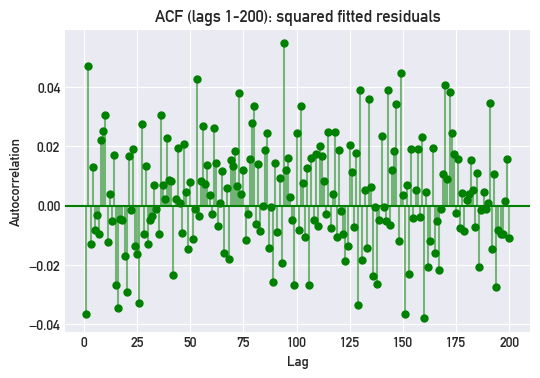

In [149]:
# ACF for squared residuals
plot_acf(
    np.square(resid),
    lags=200,
    zero=False,
    alpha=None,
    title='ACF (lags 1-200): squared fitted residuals',
    color='green', 
    vlines_kwargs={'colors': 'green', 'alpha': .5}
)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.savefig('plot/3c_2.png', dpi=plt_dpi)
plt.show()

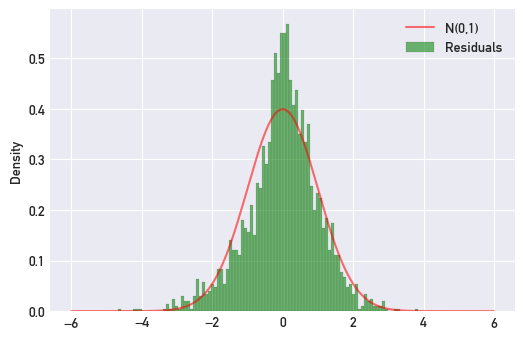

In [150]:
# d) Plot a histogram (using 100 bins) of the residuals together with the normal pdf.
x = np.linspace(-6, 6, 1000)
std_n = stats.norm.pdf(x, 0, 1)
plt.plot(x, std_n, color='red', alpha=.55)
plt.hist(
    resid,
    bins=100,
    color='green',
    edgecolor='black',
    linewidth=0.1,
    density='True',
    alpha=.55
)

# plt.title('Residual distribution with N(0,1) reference')
plt.legend(['N(0,1)', 'Residuals'])
plt.ylabel('Density')
plt.savefig('plot/3d.png', dpi=plt_dpi)
plt.show()

In [151]:
print('Residual moments:')
get_moments(pd.DataFrame(resid))

Residual moments:


,Skewness,Kurtosis
0,-0.370247,1.062814


In [152]:
print('Standard normal moments:')
get_moments(pd.DataFrame(std_n))

Standard normal moments:


,Skewness,Kurtosis
0,1.381705,0.394605


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/sit

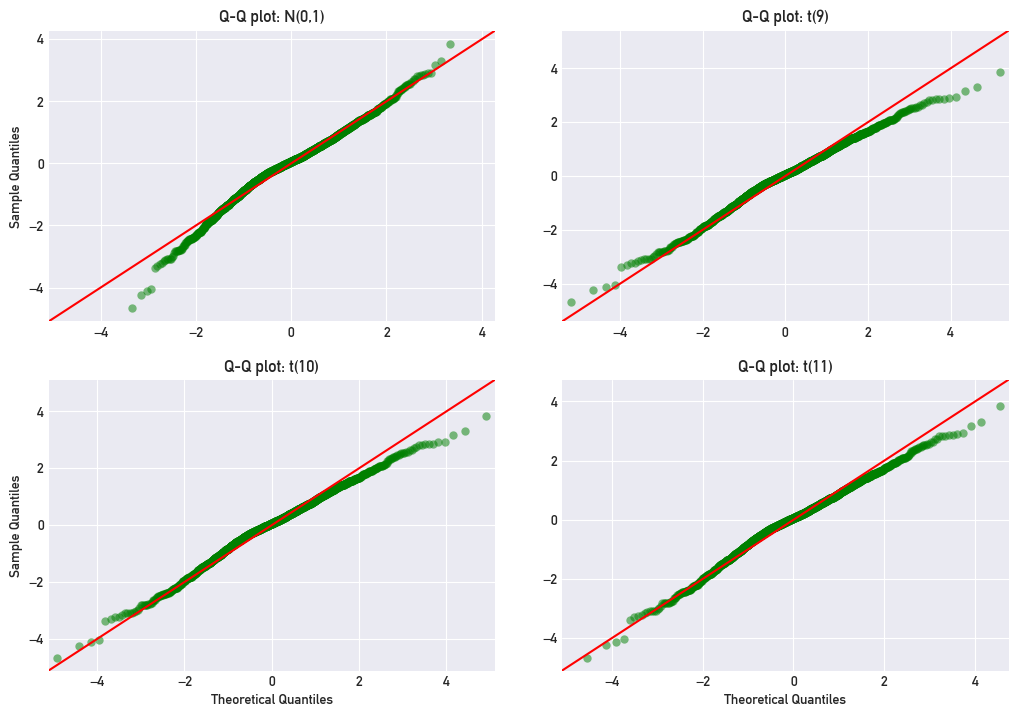

In [153]:
plt.figure(figsize=(12,8)) 
ax1 = plt.subplot(221)
sm.qqplot(resid.flatten(), dist=stats.norm, line='45', ax=ax1)
ax1.get_lines()[0].set_markeredgecolor('none')
ax1.get_lines()[0].set_markerfacecolor('green')
ax1.get_lines()[0].set_alpha(.5)
plt.xlabel(None)
plt.title('Q-Q plot: N(0,1)')

ax2 = plt.subplot(222)
sm.qqplot(resid.flatten(), dist=stats.t, distargs=(8,), line='45', ax=ax2)
ax2.get_lines()[0].set_markeredgecolor('none')
ax2.get_lines()[0].set_markerfacecolor('green')
ax2.get_lines()[0].set_alpha(.5)
plt.xlabel(None)
plt.ylabel(None)
plt.title('Q-Q plot: t(9)')

ax3 = plt.subplot(223)
sm.qqplot(resid.flatten(), dist=stats.t, distargs=(9,), line='45', ax=ax3)
ax3.get_lines()[0].set_markeredgecolor('none')
ax3.get_lines()[0].set_markerfacecolor('green')
ax3.get_lines()[0].set_alpha(.5)
plt.title('Q-Q plot: t(10)')

ax4 = plt.subplot(224)
sm.qqplot(resid.flatten(), dist=stats.t, distargs=(11,), line='45', ax=ax4)
ax4.get_lines()[0].set_markeredgecolor('none')
ax4.get_lines()[0].set_markerfacecolor('green')
ax4.get_lines()[0].set_alpha(.5)
plt.ylabel(None)
plt.title('Q-Q plot: t(11)')

plt.subplots_adjust(
    left=0.1,
    bottom=0.1, 
    right=0.9, 
    top=0.9, 
    wspace=0.15, 
    hspace=0.2
)
plt.savefig('plot/3e.png', dpi=plt_dpi)
plt.show()

## 4. VaR forecasts using GARCH and historical simulation
Use backtesting to compare daily VaR-99%-forecasts for the period 2017-01-01 -> 2020-12-31 using two versions of basic historical simulation with rolling estimation windows of length 500 and 1000 days, respectively.  
- a) Plot the VaR-forecasts in the same plot as the (negative) returns
- b) Calculate the violation ratios for the different methods and give the number of violations for each method in the report

*Discussion: What are the pros and cons of using these methods?*

### a) Compute VaR

In [154]:
dji_dat3 = yf.Ticker(ticker_id).history(start='2013-01-14', end='2020-12-31')
dji_price3 = dji_dat3[['Close']]
dji_log3 = np.log(dji_price3).diff().dropna()
dji_log3.columns = ['Log returns']
dji_log3.head()

,Log returns
Date,
2013-01-15,0.002039
2013-01-16,-0.001750
2013-01-17,0.006256
2013-01-18,0.003940
2013-01-22,0.004569


In [155]:
dji_dat3.head(-1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-01-14,13488.429688,13520.179688,13459.839844,13507.320312,118460000,0,0
2013-01-15,13507.320312,13546.370117,13445.799805,13534.889648,102280000,0,0
2013-01-16,13534.889648,13534.889648,13468.959961,13511.230469,118540000,0,0
2013-01-17,13511.230469,13633.889648,13510.240234,13596.019531,183900000,0,0
2013-01-18,13596.019531,13649.929688,13571.860352,13649.700195,260900000,0,0
...,...,...,...,...,...,...,...
2020-12-22,30200.199219,30200.199219,29992.890625,30015.509766,388810000,0,0
2020-12-23,30046.730469,30292.529297,30046.730469,30129.830078,274050000,0,0
2020-12-24,30155.919922,30209.669922,30099.300781,30199.869141,145570000,0,0


In [156]:
# 500 days window
win_size = 500
q = .01
method = 'higher'
dji_log3['VaR (HS, 500d)'] = -dji_log3['Log returns'].loc['2015-01-08':].rolling(window=win_size).quantile(q, interpolation=method)

In [157]:
# 1000 days window
win_size = 1000
q = .01
method = 'higher'
dji_log3['VaR (HS, 1000d)'] = -dji_log3['Log returns'].rolling(window=win_size).quantile(q, interpolation=method)

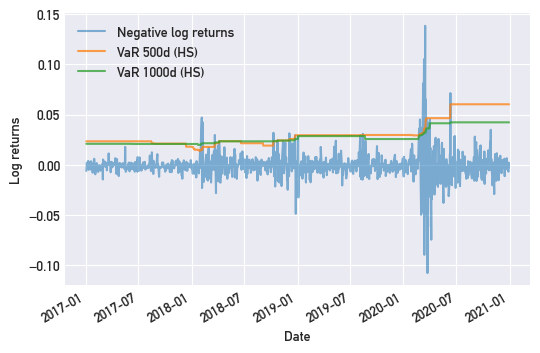

In [158]:
dat = dji_log3.loc['2017-01-01':]
ax = (-dat['Log returns']).plot(
    alpha=.55
)
dat['VaR (HS, 500d)'].plot(ax=ax, alpha=.75)
dat['VaR (HS, 1000d)'].plot(ax=ax, alpha=.75)
plt.legend(['Negative log returns', 'VaR 500d (HS)', 'VaR 1000d (HS)'])
plt.ylabel('Log returns')
plt.savefig('plot/4a.png', dpi=plt_dpi)
plt.show()

### b) Compute violation ratio

In [159]:
# b)
ret_vec = -dat['Log returns'].values
var_500 = dat['VaR (HS, 500d)'].values
var_1000 = dat['VaR (HS, 1000d)'].values

c500 = np.sum(ret_vec >= var_500)
c1000 = np.sum(ret_vec >= var_1000)
div = len(ret_vec) * 0.01

print('VaR (HS, 500 days) - violation ratio (count): {:.2f} ({:.0f} times)'.format(c500 / div, c500))
print('VaR (HS, 1000 days) - violation ratio (count): {:.2f} ({:.0f} times)'.format(c1000 / div, c1000))

VaR (HS, 500 days) - violation ratio (count): 2.09 (21 times)
VaR (HS, 1000 days) - violation ratio (count): 2.58 (26 times)


## 5. VaR forecastsusing GARCH and FHS
Repeat the backtest procedure in 4 but now based onthe GARCH-model from 2. The two models to backtest are:
- GARCH with the assumption of normally distributed conditional returns
- One-period filtered historical simulation (FHS) 

You do not need to recalibrate the GARCH-model during the backtest period.
- a) Plot the VaR-forecasts in the same plot as in 4
- b) Calculate the violation ratios

*Discussion: Whatare the pros and cons of using these methods?*


### a) Compute VaR by GARCH estimation

In [160]:
# a)
g_dat = garch_fcst_opt.loc['2017-01-01':]
phi_99 = stats.norm.ppf(0.99)
g_dat['VaR (GARCH)'] = g_dat['GARCH (hand-made)'] * phi_99
g_dat.head()

<ipython-input-160-7eb1aa59c222>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_dat['VaR (GARCH)'] = g_dat['GARCH (hand-made)'] * phi_99


,GARCH (hand-made),VaR (GARCH)
Date,,
2017-01-03,0.005426,0.012623
2017-01-04,0.005692,0.013242
2017-01-05,0.005607,0.013044
2017-01-06,0.005480,0.012748
2017-01-09,0.005439,0.012654


In [161]:
garch_fcst.head()

,GARCH
Date,
2017-01-03,0.005439
2017-01-04,0.005709
2017-01-05,0.005633
2017-01-06,0.005516
2017-01-09,0.005482


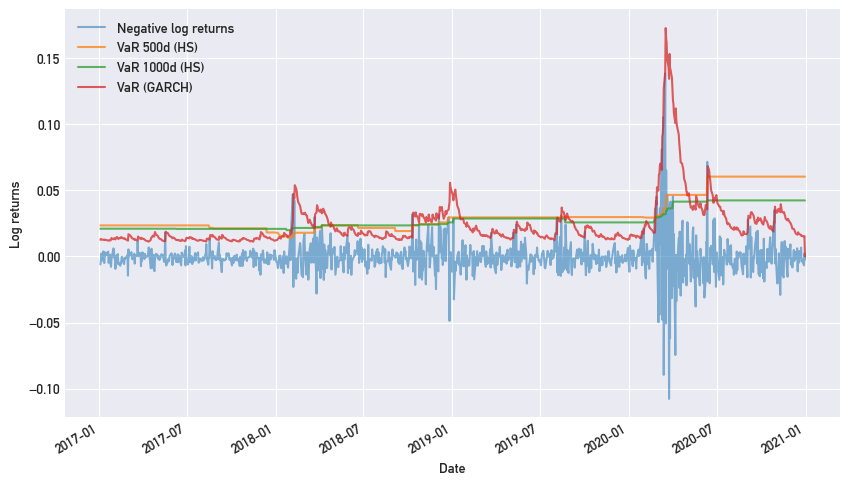

In [162]:
dat = dji_log3.loc['2017-01-01':]
ax = (-dat['Log returns']).plot(
    figsize=(10,6),
    alpha=.55
)
dat['VaR (HS, 500d)'].plot(ax=ax, alpha=.75)
dat['VaR (HS, 1000d)'].plot(ax=ax, alpha=.75)
g_dat['VaR (GARCH)'].plot(ax=ax, alpha=.75)
plt.legend(['Negative log returns', 'VaR 500d (HS)', 'VaR 1000d (HS)', 'VaR (GARCH)'])
plt.ylabel('Log returns')
plt.show()

### b) VaR by filtered historical simulation

In [163]:
# b)
sig = g_dat['GARCH (hand-made)'].values # forecasted GARCH volatilities
z = resid.flatten()
resid_qnt = np.quantile(z, q=.01)
print(f'Empirical quantile: {resid_qnt}')
print(f'Theoretical quantile: {stats.t.ppf(0.99, df=11)}')
g_dat['VaR (FHS)'] = -resid_qnt * sig

Empirical quantile: -2.77076746212281
Theoretical quantile: 2.7180791835355564


<ipython-input-163-a9a140a24dac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_dat['VaR (FHS)'] = -resid_qnt * sig


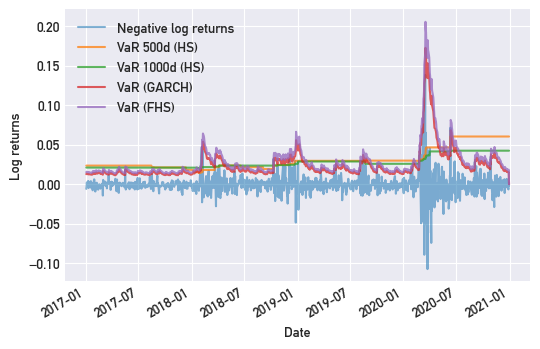

In [164]:
dat = dji_log3.loc['2017-01-01':]
ax = (-dat['Log returns']).plot(alpha=.55)
dat['VaR (HS, 500d)'].plot(ax=ax, alpha=.75)
dat['VaR (HS, 1000d)'].plot(ax=ax, alpha=.75)
g_dat['VaR (GARCH)'].plot(ax=ax, alpha=.75)
g_dat['VaR (FHS)'].plot(ax=ax, alpha=.75)
plt.legend(['Negative log returns', 'VaR 500d (HS)', 'VaR 1000d (HS)', 'VaR (GARCH)', 'VaR (FHS)'])
plt.ylabel('Log returns')
plt.savefig('plot/5a.png', dpi=plt_dpi)
plt.show()

In [165]:
# violations
# b)
ret_vec = -dat['Log returns'].values
grch = np.sum(ret_vec >= g_dat['VaR (GARCH)'].values)
fhs = np.sum(ret_vec >= g_dat['VaR (FHS)'].values)

print('VaR (HS, 500 days) - violation ratio (count): {:.3f} ({:.0f} times)'.format(c500 / div, c500))
print('VaR (HS, 1000 days) - violation ratio (count): {:.3f} ({:.0f} times)'.format(c1000 / div, c1000))
print('VaR (GARCH) - violation ratio (count): {:.3f} ({:.0f} times)'.format(grch / div, grch))
print('VaR (FHS) - violation ratio (count): {:.3f} ({:.0f} times)'.format(fhs / div, fhs))

VaR (HS, 500 days) - violation ratio (count): 2.087 (21 times)
VaR (HS, 1000 days) - violation ratio (count): 2.584 (26 times)
VaR (GARCH) - violation ratio (count): 2.286 (23 times)
VaR (FHS) - violation ratio (count): 1.491 (15 times)
